In [1]:
import torch
from time import time

from math import ceil

from botorch.models.transforms.input import AppendFeatures
from botorch.utils.transforms import normalize, unnormalize

from scalarize.test_functions.multi_objective import RocketInjector
from scalarize.utils.scalarization_functions import LengthScalarization
from scalarize.utils.scalarization_parameters import UnitVector

import matplotlib
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amssymb}"

In [2]:
def get_cvar_pareto_surface(
    ys, n_w, nadir, grid_length, alpha, output_bounds, dtype, device
):

    cvar_num = n_w - ceil(n_w * alpha) + 1
    num_objectives = output_bounds.shape[-1]

    normalized_ys = [normalize(y, output_bounds) for y in ys]
    unit_vector = UnitVector(num_objectives=num_objectives, transform_label="polar")

    u = torch.linspace(0, 1, grid_length, **tkwargs)
    WX, WY = torch.meshgrid(u, u, indexing="xy")
    Z = torch.zeros(grid_length * grid_length, num_objectives, **tkwargs)

    normalized_nadir = normalize(nadir, output_bounds)

    for i in range(grid_length):
        for j in range(grid_length):
            index = i * grid_length + j
            Wij = torch.column_stack([WX[i, j], WY[i, j]])
            weights = unit_vector(Wij)

            s_fn = LengthScalarization(weights=weights, ref_points=normalized_nadir)

            cvar_length = None
            for y in normalized_ys:
                cvar_length_x = (
                    s_fn(y)
                    .topk(cvar_num, dim=0, largest=False)
                    .values.mean(dim=0)
                    .unsqueeze(-1)
                )
                if cvar_length is None:
                    cvar_length = cvar_length_x
                else:
                    cvar_length = torch.maximum(cvar_length, cvar_length_x)

            pareto_point = normalized_nadir + cvar_length * weights
            Z[index, ...] = unnormalize(pareto_point, output_bounds)

    return Z.reshape(grid_length, grid_length, num_objectives)

In [3]:
problem = RocketInjector(negate=True)
data = torch.load("data/initial_rocket_data.pt")

noise_grid = data["noise_grid"]
nadir = data["ref_point"]
weights = data["weights"]
alpha = data["alpha"]
output_bounds = data["output_bounds"]
num_initial_points = data["num_initial_points"]
tkwargs = data["tkwargs"]
n_w = len(noise_grid)

input_transform = AppendFeatures(feature_set=noise_grid).eval()

algos = ["sobol", "nsga2", "nparego", "nehvi", "pfes", "jes", "mars", "str_hvi_ucb"]
titles = {
    "sobol": "Sobol",
    "nsga2": "NSGA2",
    "nparego": "NParEGO",
    "nehvi": "NEHVI",
    "mars": "MARS",
    "pfes": "PFES",
    "jes": "JES-LB",
    "str_hvi_ucb": "STR-HVI-UCB",
}

In [4]:
seed = 77
grid_length = 100
Xs = {}
Ys = {}

X_sets = {}
Y_sets = {}

utilities = {}
pareto_surfaces = {}

start_time = time()
for algo in algos:
    data = torch.load(f"data/rocket_feature/{str(seed).zfill(4)}_{algo}.pt")
    Xs[algo] = data["X"]
    Ys[algo] = data["Y"]
    utilities[algo] = data["utilities"][-1]

    X_sets[algo] = [input_transform(x.unsqueeze(0)) for x in Xs[algo]]
    Y_sets[algo] = [problem(x) for x in X_sets[algo]]

    pareto_surfaces[algo] = get_cvar_pareto_surface(
        ys=Y_sets[algo],
        n_w=n_w,
        nadir=nadir,
        grid_length=grid_length,
        alpha=alpha,
        output_bounds=output_bounds,
        **tkwargs,
    )
    print(f"algo={algo}, time_elapsed={time()-start_time}")

algo=sobol, time_elapsed=88.70772528648376
algo=nsga2, time_elapsed=180.59220695495605
algo=nparego, time_elapsed=273.21318006515503
algo=nehvi, time_elapsed=367.16684579849243
algo=pfes, time_elapsed=459.4909691810608
algo=jes, time_elapsed=553.0760500431061
algo=mars, time_elapsed=644.7099997997284
algo=str_hvi_ucb, time_elapsed=737.4931707382202


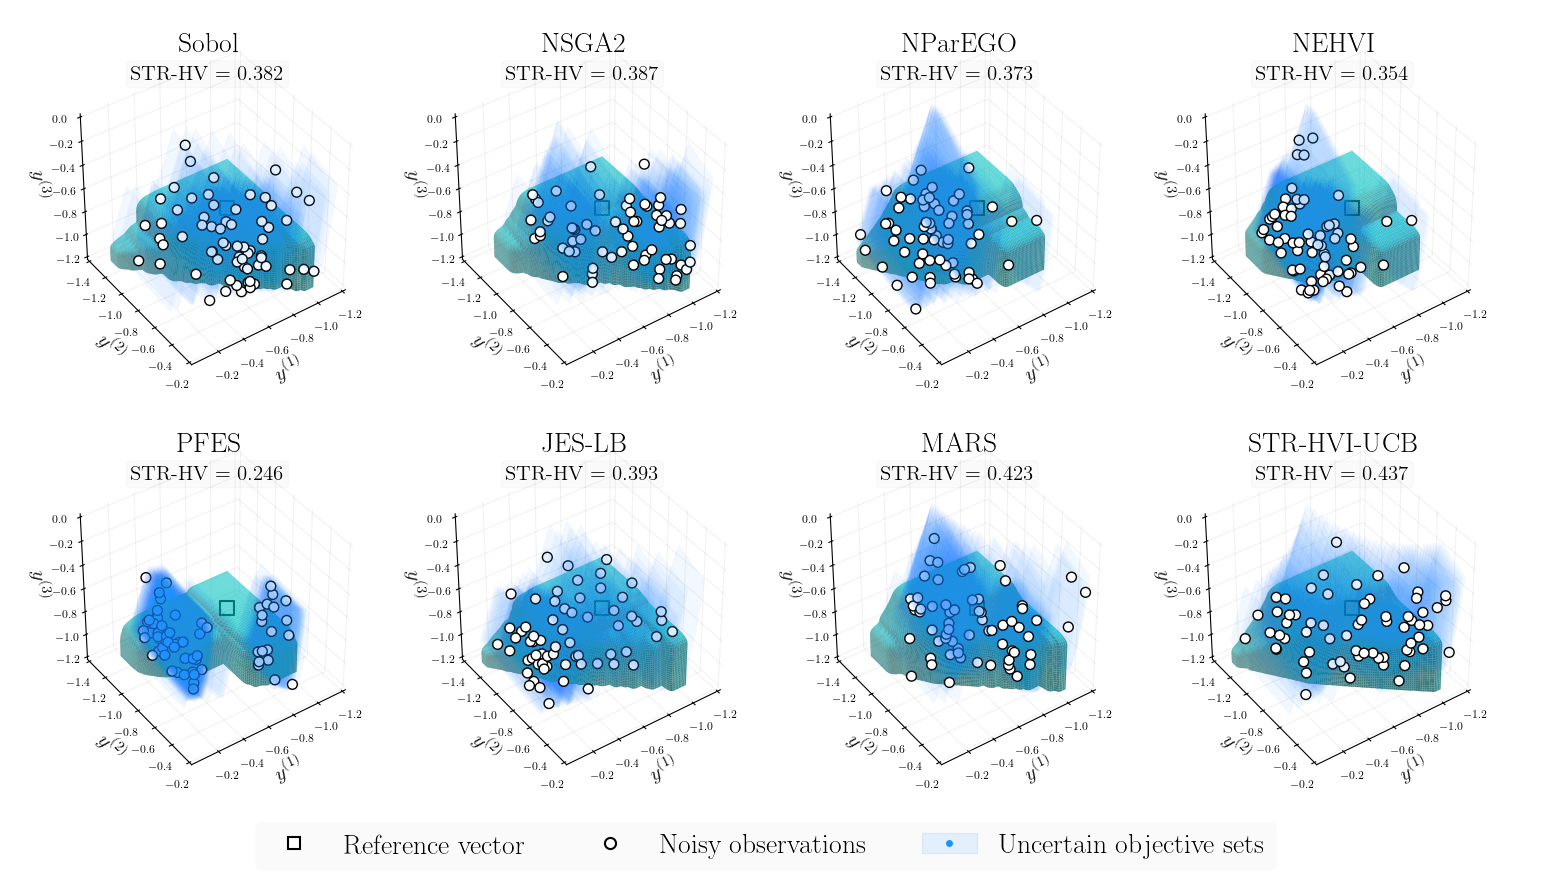

In [5]:
fig, axes = plt.subplots(figsize=(20, 8))
axes.remove()
plt.rcParams["grid.color"] = (0.5, 0.5, 0.5, 0.1)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

gs = fig.add_gridspec(4 * 2, 4 * 4)

a1s = [0, 0, 0, 0, 4, 4, 4, 4]
b1s = [0, 3, 6, 9, 0, 3, 6, 9]

for i, algo in enumerate(algos):

    ax = fig.add_subplot(gs[a1s[i] : a1s[i] + 4, b1s[i] : b1s[i] + 4], projection="3d")
    X = Xs[algo]
    Y = Ys[algo]
    utility = utilities[algo]

    X_set = X_sets[algo]
    Y_set = Y_sets[algo]

    pareto_surface = pareto_surfaces[algo]

    ax.scatter(
        xs=Y[:, 0],
        ys=Y[:, 1],
        zs=Y[:, 2],
        alpha=1,
        marker="o",
        edgecolor="k",
        color="w",
        s=50,
    )

    for z in Y_set:
        ax.plot_trisurf(
            z[:, 0],
            z[:, 1],
            z[:, 2],
            color="dodgerblue",
            alpha=0.05,
            linewidth=0,
            shade=False,
        )

    surf = ax.plot_surface(
        pareto_surface[..., 0],
        pareto_surface[..., 1],
        pareto_surface[..., 2],
        alpha=0.75,
        rstride=1,
        cstride=1,
        color="cyan",
        shade=True,
    )

    ax.set_xlabel(r"$y^{(1)}$", fontsize=15)
    ax.set_ylabel(r"$y^{(2)}$", fontsize=15)
    ax.set_zlabel(r"$y^{(3)}$", fontsize=15)

    ax.scatter(
        xs=nadir[0],
        ys=nadir[1],
        zs=nadir[2],
        color="w",
        marker="s",
        linestyle="None",
        s=100,
        edgecolors="k",
        linewidth=1.5,
    )

    ax.view_init(40, 55)
    ax.set_box_aspect(aspect=(1, 1, 1), zoom=0.8)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.xaxis.pane.set_edgecolor("w")
    ax.yaxis.pane.set_edgecolor("w")
    ax.zaxis.pane.set_edgecolor("w")

    ax.set_xlim(-1.2, -0.015)
    ax.set_ylim(-1.4, -0.2)
    ax.set_zlim(-1.2, -0.0)

    ax.tick_params(axis="x", labelsize=8)
    ax.tick_params(axis="y", labelsize=8)
    ax.tick_params(axis="z", labelsize=8)

    ax.set_title(titles[algo], fontsize=20, y=0.95)

    ax.text(
        -0.33,
        -1.35,
        0.2,
        f"STR-HV = {utility:.3f}",
        color="black",
        fontsize=15,
        weight="bold",
        bbox=dict(
            facecolor="k", edgecolor="black", boxstyle="round,pad=0.2", alpha=0.02
        ),
    )
    ####################################################################################################
    # Legend.
    if i == len(algos) - 1:
        white_square = mlines.Line2D(
            [],
            [],
            color="w",
            marker="s",
            linestyle="None",
            markersize=8,
            markeredgecolor="k",
            markeredgewidth=1.5,
        )

        white_circle = mlines.Line2D(
            [],
            [],
            color="w",
            marker="o",
            linestyle="None",
            markersize=8,
            markeredgecolor="k",
            markeredgewidth=1.5,
        )

        blue_patch = mpatches.Patch(
            color="dodgerblue",
            alpha=0.1,
        )

        blue_circle = mlines.Line2D(
            [],
            [],
            color="dodgerblue",
            marker=".",
            linestyle="None",
            markersize=8,
        )

        labels = [
            r"Reference vector",
            r"Noisy observations",
            r"Uncertain objective sets",
        ]

        ax.legend(
            handles=[
                white_square,
                white_circle,
                (blue_patch, blue_circle),
            ],
            labels=labels,
            loc=(-2.2, -0.15),
            ncol=3,
            fontsize=20,
            facecolor="k",
            framealpha=0.02,
        )

plt.show()